

#Raffy fitriadi / 22.11.5014
#William Jonathan Butar Butar / 22.11.5013

#Import Library

In [ ]:
!pip install tabulate

from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier, LogisticRegression, DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc as sklearn_auc
from tabulate import tabulate

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#Pre Processing Data

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/BIG DATA LANJUT/Heart_Disease_Prediction.csv")

In [ ]:
data.head()

index  Age  Sex  Chest pain type   BP  Cholesterol  FBS over 120  \
0      0   70    1                4  130          322             0   
1      1   67    0                3  115          564             0   
2      2   57    1                2  124          261             0   
3      3   64    1                4  128          263             0   
4      4   74    0                2  120          269             0   

   EKG results  Max HR  Exercise angina  ST depression  Slope of ST  \
0            2     109                0            2.4            2   
1            2     160                0            1.6            2   
2            0     141                0            0.3            1   
3            0     105                1            0.2            2   
4            2     121                1            0.2            1   

   Number of vessels fluro  Thallium Heart Disease  
0                        3         3      Presence  
1                        0         7       Absence  
2                        0         7      Presence  
3                        1         7       Absence  
4                        1         3       Absence

In [ ]:
data.rename(columns={
    "Age": "age",
    "Sex": "sex",
    "Chest pain type": "chest_pain_type",
    "BP": "blood_pressure",
    "Cholesterol": "cholesterol",
    "FBS over 120": "fbs_over_120",
    "EKG results": "ekg_results",
    "Max HR": "max_heart_rate",
    "Exercise angina": "exercise_angina",
    "ST depression": "st_depression",
    "Slope of ST": "slope_of_st",
    "Number of vessels fluro": "num_vessels_fluoro",
    "Thallium": "thallium",
    "Heart Disease": "heart_disease"
}, inplace=True)


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   index               270 non-null    int64  
 1   age                 270 non-null    int64  
 2   sex                 270 non-null    int64  
 3   chest_pain_type     270 non-null    int64  
 4   blood_pressure      270 non-null    int64  
 5   cholesterol         270 non-null    int64  
 6   fbs_over_120        270 non-null    int64  
 7   ekg_results         270 non-null    int64  
 8   max_heart_rate      270 non-null    int64  
 9   exercise_angina     270 non-null    int64  
 10  st_depression       270 non-null    float64
 11  slope_of_st         270 non-null    int64  
 12  num_vessels_fluoro  270 non-null    int64  
 13  thallium            270 non-null    int64  
 14  heart_disease       270 non-null    object 
dtypes: float64(1), int64(13), object(1)
memory usage: 31.8+ K

# EDA


In [ ]:
!pip install ydata-profiling
from ydata_profiling import ProfileReport

In [ ]:
profile = ProfileReport(data, title="Pandas Profiling Report", explorative=True)

profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
print("\nSummary Data:")
print(data.describe(include="all"))


Summary Data:
          df_index         age         sex  chest_pain_type  blood_pressure  \
count   270.000000  270.000000  270.000000       270.000000      270.000000   
unique         NaN         NaN         NaN              NaN             NaN   
top            NaN         NaN         NaN              NaN             NaN   
freq           NaN         NaN         NaN              NaN             NaN   
mean    134.500000   54.433333    0.677778         3.174074      131.344444   
std      78.086491    9.109067    0.468195         0.950090       17.861608   
min       0.000000   29.000000    0.000000         1.000000       94.000000   
25%      67.250000   48.000000    0.000000         3.000000      120.000000   
50%     134.500000   55.000000    1.000000         3.000000      130.000000   
75%     201.750000   61.000000    1.000000         4.000000      140.000000   
max     269.000000   77.000000    1.000000         4.000000      200.000000   

        cholesterol  fbs_over_120  e

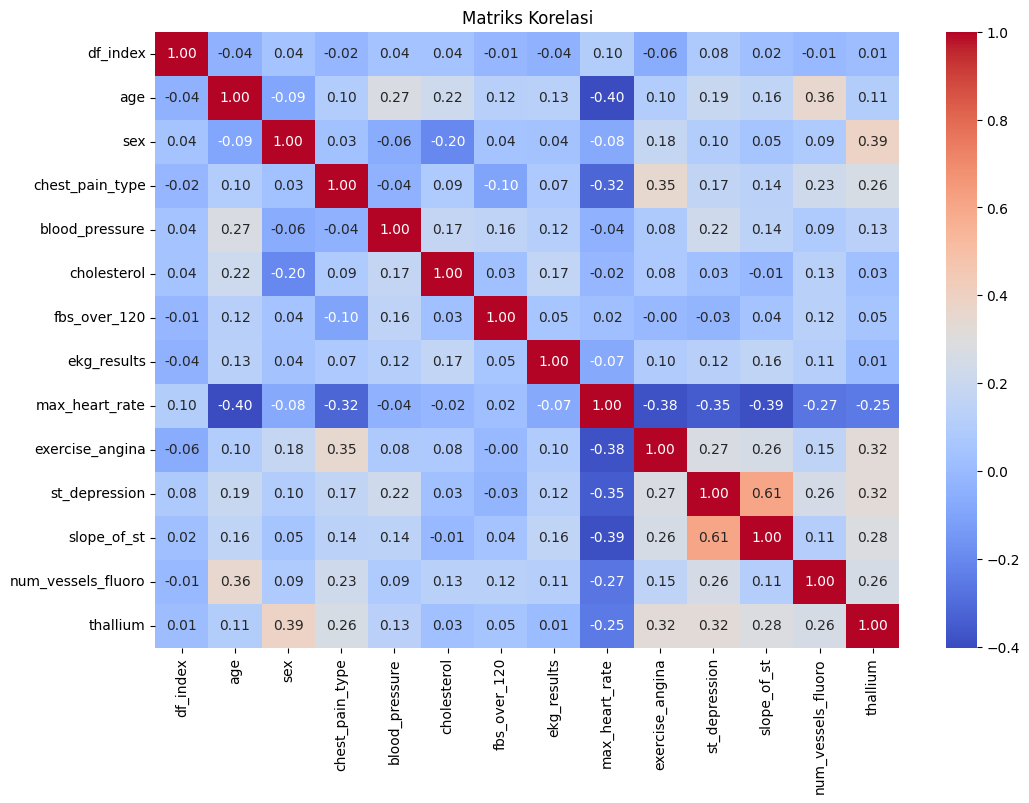

In [ ]:
#Menampilkan matriks korelasi
plt.figure(figsize=(12, 8))
correlation_matrix = data.corr(numeric_only=True)
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriks Korelasi")
plt.show()

<ipython-input-14-ef4f9c3a5b29>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x="sex", palette="viridis")


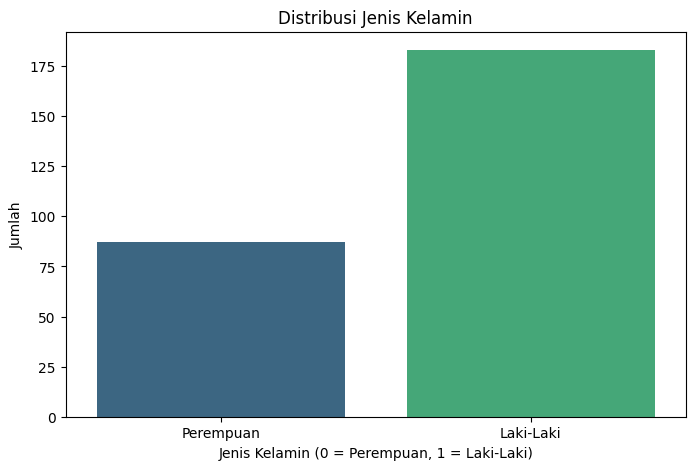

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Bar Chart: Distribusi Jenis Kelamin
plt.figure(figsize=(8, 5))
sns.countplot(data=data, x="sex", palette="viridis")
plt.title("Distribusi Jenis Kelamin")
plt.xlabel("Jenis Kelamin (0 = Perempuan, 1 = Laki-Laki)")
plt.ylabel("Jumlah")
plt.xticks([0, 1], ["Perempuan", "Laki-Laki"])
plt.show()

# Penjelasan: Bar chart ini menunjukkan distribusi jumlah laki-laki dan perempuan dalam dataset.

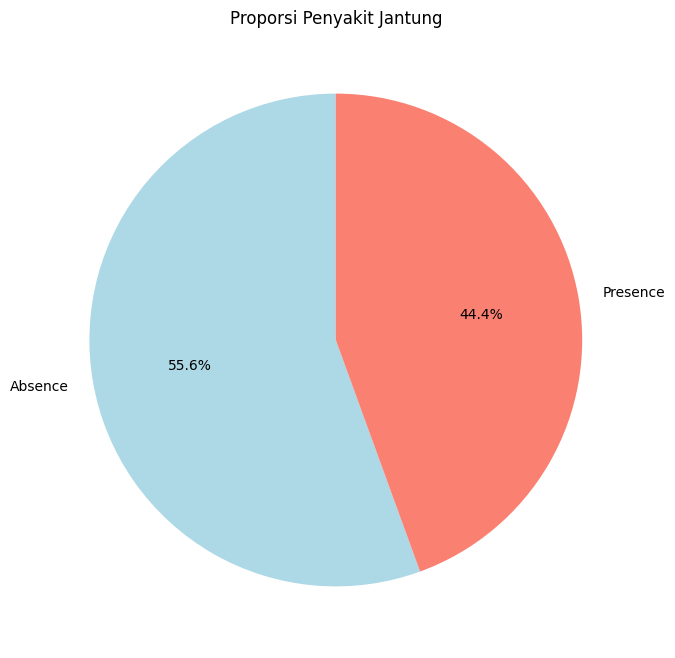

In [ ]:
# Pie Chart: Proporsi Pasien dengan dan tanpa Penyakit Jantung
plt.figure(figsize=(8, 8))
data["heart_disease"].value_counts().plot.pie(
    autopct='%1.1f%%', startangle=90, colors=["lightblue", "salmon"], labels=["Absence", "Presence"]
)
plt.title("Proporsi Penyakit Jantung")
plt.ylabel("")
plt.show()

# Penjelasan: Pie chart ini memberikan gambaran proporsi pasien dengan penyakit jantung (Presence) dan tanpa penyakit jantung (Absence).



<ipython-input-16-8c0051410bac>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x="heart_disease", y="blood_pressure", palette="coolwarm")


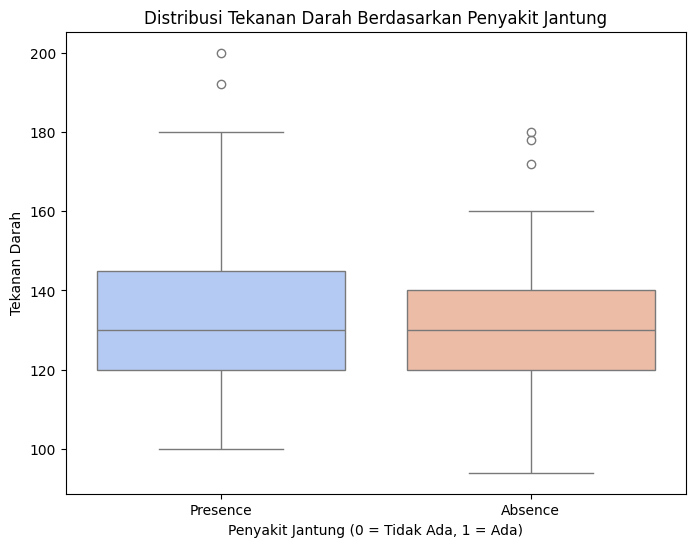

In [ ]:
# Box Plot: Distribusi Tekanan Darah Berdasarkan Penyakit Jantung
plt.figure(figsize=(8, 6))
sns.boxplot(data=data, x="heart_disease", y="blood_pressure", palette="coolwarm")
plt.title("Distribusi Tekanan Darah Berdasarkan Penyakit Jantung")
plt.xlabel("Penyakit Jantung (0 = Tidak Ada, 1 = Ada)")
plt.ylabel("Tekanan Darah")
plt.show()

# Penjelasan: Box plot ini menunjukkan distribusi tekanan darah untuk pasien dengan dan tanpa penyakit jantung.


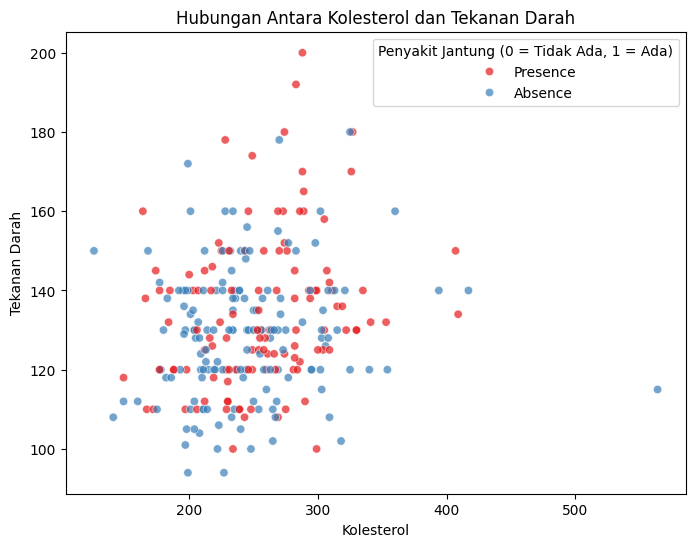

In [ ]:
# Scatter Plot: Hubungan Antara Kolesterol dan Tekanan Darah
plt.figure(figsize=(8, 6))
sns.scatterplot(data=data, x="cholesterol", y="blood_pressure", hue="heart_disease", palette="Set1", alpha=0.7)
plt.title("Hubungan Antara Kolesterol dan Tekanan Darah")
plt.xlabel("Kolesterol")
plt.ylabel("Tekanan Darah")
plt.legend(title="Penyakit Jantung (0 = Tidak Ada, 1 = Ada)")
plt.show()

# Penjelasan: Scatter plot ini menunjukkan hubungan antara tingkat kolesterol dan tekanan darah, dengan warna menunjukkan keberadaan penyakit jantung.

# Klasifikasi Machine Learning

In [ ]:
# Initialize Spark session
spark = SparkSession.builder.appName("HeartDiseasePrediction").getOrCreate()

# Load the data
data = spark.read.csv("/content/drive/MyDrive/BIG DATA LANJUT/Heart_Disease_Prediction.csv", header=True, inferSchema=True)

# Rename columns
data = data.withColumnRenamed("Age", "age") \
           .withColumnRenamed("Sex", "sex") \
           .withColumnRenamed("Chest pain type", "chest_pain_type") \
           .withColumnRenamed("BP", "blood_pressure") \
           .withColumnRenamed("Cholesterol", "cholesterol") \
           .withColumnRenamed("FBS over 120", "fbs_over_120") \
           .withColumnRenamed("EKG results", "ekg_results") \
           .withColumnRenamed("Max HR", "max_heart_rate") \
           .withColumnRenamed("Exercise angina", "exercise_angina") \
           .withColumnRenamed("ST depression", "st_depression") \
           .withColumnRenamed("Slope of ST", "slope_of_st") \
           .withColumnRenamed("Number of vessels fluro", "num_vessels_fluoro") \
           .withColumnRenamed("Thallium", "thallium") \
           .withColumnRenamed("Heart Disease", "heart_disease")

In [ ]:
# Convert categorical columns to numeric
categorical_columns = ["sex", "chest_pain_type", "fbs_over_120", "ekg_results", "exercise_angina", "slope_of_st", "num_vessels_fluoro", "thallium"]
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(data) for column in categorical_columns]

for indexer in indexers:
    data = indexer.transform(data)

# Convert heart_disease column to numeric
heart_disease_indexer = StringIndexer(inputCol="heart_disease", outputCol="heart_disease_index")
data = heart_disease_indexer.fit(data).transform(data)

# Assemble features
feature_columns = ["age", "blood_pressure", "cholesterol", "max_heart_rate", "st_depression"] + [column+"_index" for column in categorical_columns]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data = assembler.transform(data)

# Split the data
train_data, test_data = data.randomSplit([0.8, 0.2], seed=1234)

Confusion Matrix for Random Forest:
[[37  4]
 [ 6 18]]



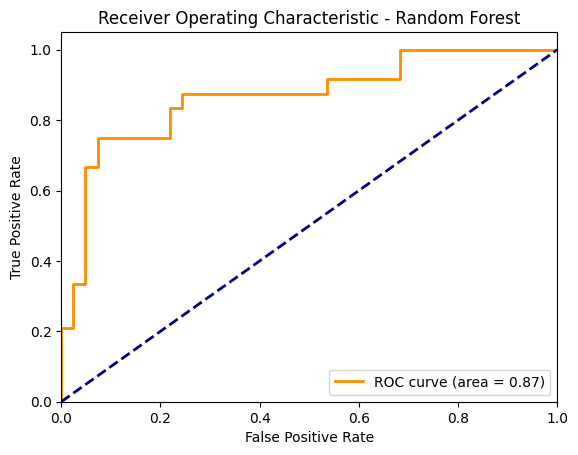

Confusion Matrix for Gradient Boosted Tree:
[[33  8]
 [ 9 15]]



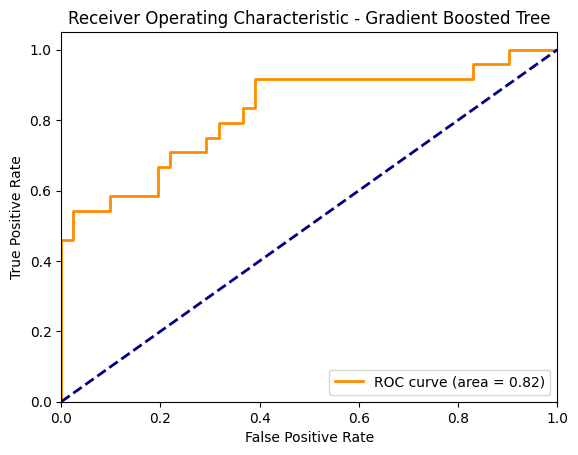

Confusion Matrix for Logistic Regression:
[[37  4]
 [ 8 16]]



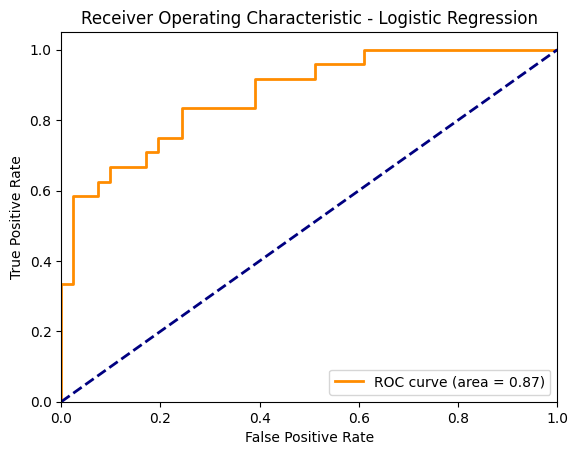

Confusion Matrix for Decision Tree:
[[35  6]
 [ 8 16]]



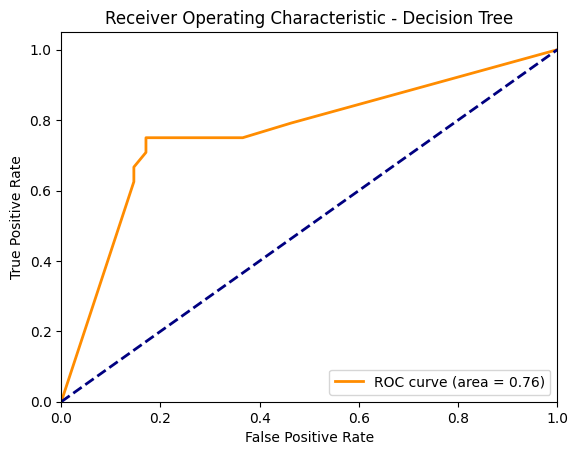


Hasil Evaluasi:
+-----------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|         Model         |        AUC         |      Accuracy      |      F1 Score      |     Precision      |       Recall       |
+-----------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|     Random Forest     | 0.866869918699187  | 0.8461538461538461 | 0.8446408663799968 | 0.8448528215970077 | 0.8461538461538461 |
| Gradient Boosted Tree | 0.8231707317073172 | 0.7384615384615385 | 0.7372547473034526 |  0.73640707118968  | 0.7384615384615385 |
|  Logistic Regression  | 0.8719512195121951 | 0.8153846153846154 | 0.8112863880305741 | 0.8140170940170941 | 0.8153846153846154 |
|     Decision Tree     |        0.75        | 0.7846153846153846 | 0.7824972129319954 | 0.7819482842738656 | 0.7846153846153846 |
+-----------------------+--------------------+--------------------

In [ ]:
# Initialize models
rf = RandomForestClassifier(labelCol="heart_disease_index", featuresCol="features")
gbt = GBTClassifier(labelCol="heart_disease_index", featuresCol="features")
lr = LogisticRegression(labelCol="heart_disease_index", featuresCol="features")
dt = DecisionTreeClassifier(labelCol="heart_disease_index", featuresCol="features")

# Train models
rf_model = rf.fit(train_data)
gbt_model = gbt.fit(train_data)
lr_model = lr.fit(train_data)
dt_model = dt.fit(train_data)

# Initialize evaluators
binary_evaluator = BinaryClassificationEvaluator(labelCol="heart_disease_index")
multi_evaluator = MulticlassClassificationEvaluator(labelCol="heart_disease_index")

# Evaluate models and plot ROC curve
models = [rf_model, gbt_model, lr_model, dt_model]
model_names = ["Random Forest", "Gradient Boosted Tree", "Logistic Regression", "Decision Tree"]

def plot_roc_curve(predictions, label):
    y_true = predictions.select("heart_disease_index").collect()
    y_score = predictions.select("probability").collect()
    y_true = [row[0] for row in y_true]
    y_score = [row[0][1] for row in y_score]

    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = sklearn_auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {label}')
    plt.legend(loc="lower right")
    plt.show()

model_metrics = []

for model, name in zip(models, model_names):
    predictions = model.transform(test_data)

    auc = binary_evaluator.evaluate(predictions, {binary_evaluator.metricName: "areaUnderROC"})
    accuracy = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "accuracy"})
    f1 = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "f1"})
    precision = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "weightedPrecision"})
    recall = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "weightedRecall"})

    model_metrics.append({
        "Model": name,
        "AUC": auc,
        "Accuracy": accuracy,
        "F1 Score": f1,
        "Precision": precision,
        "Recall": recall
    })

    y_true = predictions.select("heart_disease_index").collect()
    y_pred = predictions.select("prediction").collect()
    y_true = [row[0] for row in y_true]
    y_pred = [row[0] for row in y_pred]

    cm = confusion_matrix(y_true, y_pred)
    print(f"Confusion Matrix for {name}:\n{cm}\n")

    plot_roc_curve(predictions, name)

# Display evaluation results in a tabular format
import pandas as pd
df_results = pd.DataFrame(model_metrics)
print("\nHasil Evaluasi:")
print(tabulate(df_results, headers="keys", tablefmt="pretty", showindex=False))

# Hyperparameter Tuning

In [ ]:
# Select the two best models based on AUC
model_metrics.sort(key=lambda x: x["AUC"], reverse=True)
best_models = model_metrics[:2]


print("Top 2 Models: ",)
print(best_models)

Top 2 Models: 
[{'Model': 'Logistic Regression', 'AUC': 0.8719512195121951, 'Accuracy': 0.8153846153846154, 'F1 Score': 0.8112863880305741, 'Precision': 0.8140170940170941, 'Recall': 0.8153846153846154}, {'Model': 'Random Forest', 'AUC': 0.866869918699187, 'Accuracy': 0.8461538461538461, 'F1 Score': 0.8446408663799968, 'Precision': 0.8448528215970077, 'Recall': 0.8461538461538461}]


In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline

# Define evaluators
binary_evaluator = BinaryClassificationEvaluator(labelCol="heart_disease_index", metricName="areaUnderROC")

# Logistic Regression Hyperparameter Tuning
lr = LogisticRegression(labelCol="heart_disease_index", featuresCol="features")

# Param grid for Logistic Regression
lr_paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 0.5]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

# Cross-validation for Logistic Regression
lr_crossval = CrossValidator(estimator=lr,
                             estimatorParamMaps=lr_paramGrid,
                             evaluator=binary_evaluator,
                             numFolds=5)

# Fit model for Logistic Regression
lr_cv_model = lr_crossval.fit(train_data)
lr_predictions = lr_cv_model.transform(test_data)

# Evaluate Logistic Regression
lr_auc = binary_evaluator.evaluate(lr_predictions, {binary_evaluator.metricName: "areaUnderROC"})
lr_accuracy = lr_auc # You can also use a different evaluator for accuracy
print(f"Tuned Logistic Regression - AUC: {lr_auc}, Accuracy: {lr_accuracy}")

# Random Forest Hyperparameter Tuning
rf = RandomForestClassifier(labelCol="heart_disease_index", featuresCol="features")

# Param grid for Random Forest
rf_paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 20, 30]) \
    .addGrid(rf.maxDepth, [5, 10, 15]) \
    .build()

# Cross-validation for Random Forest
rf_crossval = CrossValidator(estimator=rf,
                             estimatorParamMaps=rf_paramGrid,
                             evaluator=binary_evaluator,
                             numFolds=5)

# Fit model for Random Forest
rf_cv_model = rf_crossval.fit(train_data)
rf_predictions = rf_cv_model.transform(test_data)

# Evaluate Random Forest
rf_auc = binary_evaluator.evaluate(rf_predictions, {binary_evaluator.metricName: "areaUnderROC"})
rf_accuracy = rf_auc  # You can also use a different evaluator for accuracy
print(f"Tuned Random Forest - AUC: {rf_auc}, Accuracy: {rf_accuracy}")

# Optionally, print confusion matrix for both models
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import confusion_matrix

# Logistic Regression Confusion Matrix
lr_y_true = lr_predictions.select("heart_disease_index").collect()
lr_y_pred = lr_predictions.select("prediction").collect()
lr_y_true = [row[0] for row in lr_y_true]
lr_y_pred = [row[0] for row in lr_y_pred]
lr_cm = confusion_matrix(lr_y_true, lr_y_pred)
print(f"Confusion Matrix for Tuned Logistic Regression:\n{lr_cm}\n")

# Random Forest Confusion Matrix
rf_y_true = rf_predictions.select("heart_disease_index").collect()
rf_y_pred = rf_predictions.select("prediction").collect()
rf_y_true = [row[0] for row in rf_y_true]
rf_y_pred = [row[0] for row in rf_y_pred]
rf_cm = confusion_matrix(rf_y_true, rf_y_pred)
print(f"Confusion Matrix for Tuned Random Forest:\n{rf_cm}\n")


Tuned Logistic Regression - AUC: 0.8790650406504066, Accuracy: 0.8790650406504066
Tuned Random Forest - AUC: 0.8953252032520328, Accuracy: 0.8953252032520328
Confusion Matrix for Tuned Logistic Regression:
[[37  4]
 [ 8 16]]

Confusion Matrix for Tuned Random Forest:
[[39  2]
 [ 8 16]]



PENJELASAN SOAL :
1. Berdasarkan apa yang sudah anda pelajari, silahkan gunakan kemampuan anda untuk menyelesaikan sebuah menggunakan classification yang melibatksn penggunaan Machine Learning ?

  a.  Pilih satu bidang yang Anda beserta rekan tim minati, jabarkan alasan pemilihan bidang tersebut dan jelaskan apa yang ingin dicapai dengan memilih topik ini

  Jawab = Heart_Disease_Prediction

  Alasan : Penyakit jantung merupakan salah satu penyebab utama kematian di seluruh dunia. Mendeteksi penyakit jantung lebih awal dapat membantu mencegah komplikasi yang lebih serius dan meningkatkan kualitas hidup penderita. Dengan menggunakan machine learning, kita dapat membangun model prediksi yang dapat membantu dokter dan pasien dalam mengambil keputusan yang lebih tepat. Menggunakan data historis dan faktor risiko, model ini dapat memberikan prediksi yang akurat tentang kemungkinan seseorang mengidap penyakit jantung.

  Tujuan : Tujuan utama dari memilih topik ini adalah untuk mengembangkan model machine learning yang dapat mengidentifikasi risiko penyakit jantung berdasarkan data medis dan faktor-faktor risiko seperti tekanan darah, tingkat kolesterol, usia, jenis kelamin, dan riwayat keluarga. Prediksi yang akurat akan meningkatkan kesadaran masyarakat tentang pentingnya gaya hidup sehat serta memberikan alat bantu bagi profesional medis dalam penanganan penyakit jantung.

  b.  Ceritakan proses mendapatkan data dan informasi lengkap mengenai data tersebut (seperti waktu, penjelasan setiap kolom, sumber dll). Data yang digunakan harus data terbaru dengan range 1-4 tahun kebelakang.

  Jawab : Dataset kami dapatkan dari keggle dengan periode data 4 tahun terkahir

  e. berdasarkan analisis data tersebut, jelaskan alasan pemilihan kolom/fitur yang relevan untuk menyelesaikan permasalahan yang ingin dicapai.


2. Pengembangan model machine learning

   b. Dari ke-4 model classification tersebut, pilih dua model dengan performa terbaik dan lakukan hyperparameter tuning untuk melihat perubahan performa yang dihasilkan. Lalu tentukan model terbaik yang bisa menjadi solusi pada masalah yang anda tetapkan diawal.

   Jawab : Dari keempat model yang dievaluas, dua model dengan performa terbaik adalah Random Forest dan Logistic Regression, berdasarkan hasil evaluasi awal. Setelah dilakukan hyperparameter tuning, hasil menunjukan bahawa

Tuned Random Forest
- AUC: 0.8953252032520328, Accuracy: 0.8953252032520328

 Tuned Logistic Regression
 - AUC: 0.8790650406504066, Accuracy: 0.8790650406504066